# Car Number Plate Recognition

This project focuses on automatic car number plate recognition from vehicle images. The system detects the license plate region and recognizes the characters using a deep learning–based OCR model. Training is performed with a CTC loss function, which is suitable for variable-length license plate text without requiring character-level alignment. Due to the limited size of the training dataset (approximately 500 images), the model is trained under data-scarce conditions. Despite this limitation, the system achieves a recognition accuracy of 79% on validation data, indicating promising performance and potential for improvement with a larger dataset.

<br> Data set is provided form [`Car Number Plate Dataset`](https://www.kaggle.com/datasets/sujaymann/car-number-plate-dataset-yolo-format)

## Outline
- [ 1 - Result model examples](#1---result-model-examples)
- [ 2 - Result accuracy](#2---result-accuracy)

<a name="1"></a>
## 1 - Result model examples

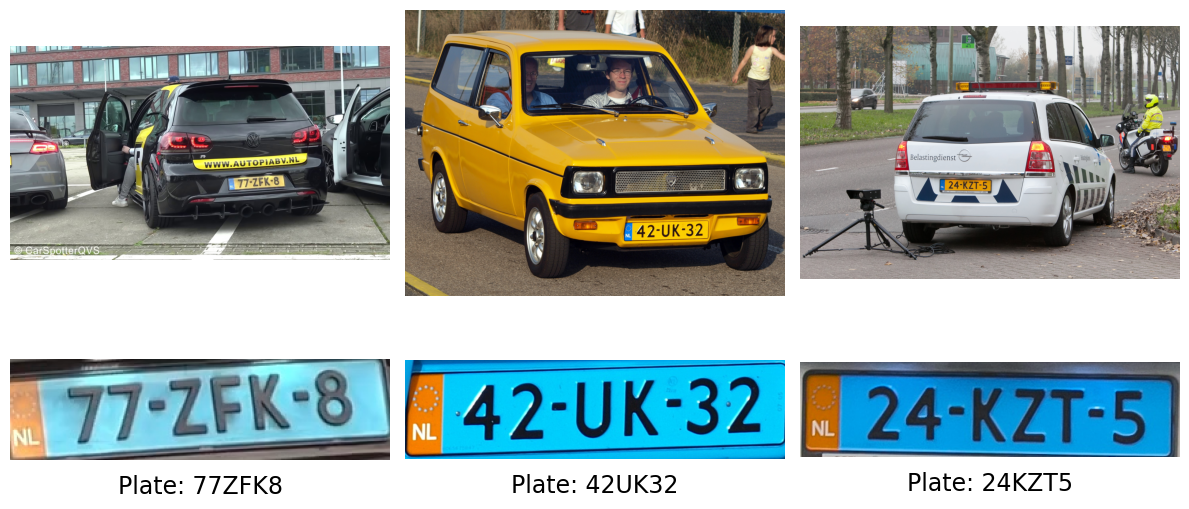

In [11]:
plot_image(img_list)

In [3]:
import matplotlib.pyplot as plt
import numpy as np

from config import VAL_IMAGES, charset, CHAR_MODEL_CONFIG,TRAIN_IMAGES
from src.utils import predict_and_crop, get_latest_model_new
from src.models import TinyOCR, box_model
from src.utils.char_utils import *
from src.dataset import OCRFileDataset, collate_fn, augment_image

from torch.utils.data import DataLoader, ConcatDataset, Subset

import os
import torch

In [4]:
import importlib
import src.utils
importlib.reload(src.utils)
from src.utils import predict_and_crop

In [5]:
VAL_IMAGES = TRAIN_IMAGES

In [6]:
img_list = ["N1.jpeg", "N2.jpeg", "N4.jpeg"]

In [10]:
def plot_images_with_text(originals, plates, texts):
    """
    originals: list of images (PIL or np.array)
    plates: list of images (PIL or np.array)
    texts: list of strings (plate numbers)
    """
    assert len(originals) == len(plates) == len(texts)

    n = len(originals)
    fig, axes = plt.subplots(2, n, figsize=(4 * n, 6))

    # Normalize axes shape when n == 1
    if n == 1:
        axes = np.array([[axes[0]], [axes[1]]])

    for i in range(n):
        # --- Original image ---
        img = originals[i]
        if not isinstance(img, np.ndarray):
            img = np.array(img)
        axes[0, i].imshow(img)
        axes[0, i].axis("off")

        # --- Plate text ---
        axes[1, i].text(
            0.5, -0.15,
            f"Plate: {texts[i]}",
            ha="center",
            va="top",
            fontsize=17,
            transform=axes[1, i].transAxes
        )
        # --- Plate image ---
        plate = plates[i]
        if not isinstance(plate, np.ndarray):
            plate = np.array(plate)
        axes[1, i].imshow(plate, cmap="gray" if plate.ndim == 2 else None)
        axes[1, i].axis("off")

    plt.tight_layout()
    plt.show()

In [8]:
def plot_image(list_img):
    blank_idx = len(charset)

    best_char_model = get_latest_model_new(CHAR_MODEL_CONFIG["FOLDER"])
    model = TinyOCR(CHAR_MODEL_CONFIG["num_classes"])
    model.load_state_dict(torch.load(best_char_model))
    model.eval()

    originals = []
    plates = []
    decoded_texts = []

    for img in list_img:

        # Load image if path
        if isinstance(img, str):
            original = Image.open(os.path.join(VAL_IMAGES, img))
        else:
            original = img

        originals.append(original)

        # Plate detection
        plate = predict_and_crop(box_model, original)
        plates.append(plate)

        # OCR
        img_1 = read_img(plate, CHAR_MODEL_CONFIG["img_h"])

        with torch.no_grad():
            logits = model(img_1)
            pred = logits.argmax(dim=2).squeeze(1).cpu()

        decoded = ctc_decode(pred, blank_idx, charset)
        decoded_texts.append(decoded)

    plot_images_with_text(
        originals=originals,
        plates=plates,
        texts=decoded_texts
    )

<a name="2"></a>
## 2 - Result accuracy

In [49]:
model_name = torch.load(get_latest_model_new(CHAR_MODEL_CONFIG["FOLDER"]))
num_classes = len(charset) + 1  # blank
model = TinyOCR(num_classes)
model.load_state_dict(model_name)

<All keys matched successfully>

In [65]:
batch_size=4
blank_idx = len(charset)
val = os.path.join(CHAR_MODEL_CONFIG["crop_data"], "val")

In [51]:
val_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.5], std=[0.5]),
    T.Lambda(lambda x: 1.0 - x)
])

In [66]:
dataset_val = OCRFileDataset(os.path.join(val, "images"), os.path.join(val, "labels"), transform=val_transform)

data_loader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

Loaded 125 samples (filtered)


In [67]:
exact_val, char_acc_val, all_preds, all_gts = evaluate_accuracy(model, data_loader_val, blank_idx, charset, device = "cpu")

In [79]:
print(f"Final character accuracy for test data: {char_acc_val * 100:.2f}%")

Final character accuracy for test data: 78.97%


In [75]:
print(f"First 5 predicted plates: {all_preds[:5]}")

First 5 predicted plates: ['MMOOI', 'MH12JC2813', 'IO9ETL', 'MH20EE7598', 'ALR486']


In [80]:
print(f"First 5 ground true: {all_gts[:5]}")

First 5 ground true: ['HNYCHIL3', 'MH12JC2813', 'EVO9FTW', 'MH20EE7598', 'ALR486']
